# LLM fine-tuning

## Goal

Fine-tune an LLM to learn to count objects in a grid, or to solve ARC tasks.

I might do 2 steps of fine-tuning:

1. Learning priors, f.e. learning to count
2. Solve ARC tasks

## References

- https://github.com/ironbar/prompt_recovery/blob/main/notebooks/012_fine-tune_llama.ipynb
- https://www.kaggle.com/code/ironbar/few-shot-prompting-for-arc24

## Imports

In [23]:
import json
from abc import ABC, abstractmethod
import numpy as np
from termcolor import colored
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from datasets import Dataset

plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (20, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

## Configuration

In [24]:
class cfg:
    model_path = "/home/gbarbadillo/data/Phi-3-mini-128k-instruct"
    dataset = '/mnt/hdd0/Kaggle/arc24/data/learn_to_count_10000.json'
    val_samples = 1000
    max_seq_len = 512
    random_seed = 42
    output_dir = '/mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug'

## Model

In [3]:
model = AutoModelForCausalLM.from_pretrained(
    cfg.model_path,
    #quantization_config=bnb_config,
    device_map='balanced',
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    cfg.model_path,
    trust_remote_code=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
tokenizer.special_tokens_map

{'bos_token': '<s>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<unk>',
 'pad_token': '<|endoftext|>'}

In [6]:
def print_gpu_memory():
    for device in range(torch.cuda.device_count()):
        print(f'GPU {device} memory allocated: {torch.cuda.memory_allocated(device)/1024**3:.1f} GB, max memory allocated: {torch.cuda.max_memory_allocated(device)/1024**3:.1f} GB')
print_gpu_memory()

GPU 0 memory allocated: 3.6 GB, max memory allocated: 3.6 GB
GPU 1 memory allocated: 3.6 GB, max memory allocated: 3.6 GB


## Data

### Grid encoders

In [7]:
class GridEncoder(ABC):
    @abstractmethod
    def to_text(self, grid):
        pass
    
    @abstractmethod
    def to_grid(self, text):
        pass

In [8]:
sample_grid = np.eye(3, dtype=int).tolist()

def test_translator(translator):
    assert sample_grid == translator.to_grid(translator.to_text(sample_grid))
    print(translator.to_text(sample_grid))

In [9]:
class MinimalGridEncoder(GridEncoder):
    @staticmethod
    def to_text(grid):
        text = '\n'.join([''.join([str(x) for x in line]) for line in grid])
        return text
    
    @staticmethod
    def to_grid(text):
        lines = text.strip().splitlines()
        grid = [[int(x) for x in line] for line in lines]
        return grid
        
test_translator(MinimalGridEncoder())

100
010
001


In [10]:
class GridWithSeparationEncoder(GridEncoder):
    def __init__(self, split_symbol):
        self.split_symbol = split_symbol

    def to_text(self, grid):
        text = '\n'.join([self.split_symbol.join([str(x) for x in line]) for line in grid])
        return text

    def to_grid(self, text):
        lines = text.strip().splitlines()
        grid = [[int(x) for x in line.split(self.split_symbol)] for line in lines]
        return grid

test_translator(GridWithSeparationEncoder('|'))

1|0|0
0|1|0
0|0|1


In [11]:
class GridCodeBlockEncoder(GridEncoder):
    def __init__(self, base_encoder):
        self.encoder = base_encoder

    def to_text(self, grid):
        text = f'```grid\n{self.encoder.to_text(grid)}\n```'
        return text

    def to_grid(self, text):
        grid_text = text.split('```grid\n')[1].split('\n```')[0]
        grid = self.encoder.to_grid(grid_text)
        return grid

test_translator(GridCodeBlockEncoder(MinimalGridEncoder()))

test_translator(GridCodeBlockEncoder(GridWithSeparationEncoder('|')))

```grid
100
010
001
```
```grid
1|0|0
0|1|0
0|0|1
```


### Load data

In [12]:
with open(cfg.dataset) as f:
    data = json.load(f)
print(f'There are {len(data)} samples in the dataset')

There are 9995 samples in the dataset


### Format data

In [13]:
encoder = GridCodeBlockEncoder(MinimalGridEncoder())

In [14]:
def pretty_print_prompt(text, default_color='white'):
    color = default_color
    attrs = None
    for line in text.splitlines():
        if line.startswith('<|assistant|>'):
            color = 'blue'
        elif line.startswith('<|user|>'):
            color = default_color
        elif line.startswith('<|system|>'):
            color = 'green'
        if line.startswith('<'):
            attrs = ['bold']
        else:
            attrs = None
        print(colored(line, color, attrs=attrs))

In [15]:
prompts = []

for sample_id, sample in tqdm(data.items(), total=len(data)):
    first_message = True
    messages = [{'role': 'system', 'content': 'You are a helpful AI assistant'}]
    for question, answer in sample['questions'].items():
        if first_message:
            content = encoder.to_text(sample['grid']) + '\n' + question
            first_message = False
        else:
            content = question
        messages.append({'role': 'user', 'content': content})
        messages.append({'role': 'assistant', 'content': str(answer)})
    prompt = tokenizer.apply_chat_template(messages,
                                           tokenize=False,
                                           add_generation_prompt=True)
    prompts.append(prompt)

  0%|          | 0/9995 [00:00<?, ?it/s]

In [16]:
pretty_print_prompt(prompts[0])

<|system|>
You are a helpful AI assistant<|end|>
<|user|>
```grid
00086
02000
02100
21112
20112
```
How many objects are there in the grid?<|end|>
<|assistant|>
5<|end|>
<|user|>
Please list the area of all the objects in the grid, in ascending order and separated by commas<|end|>
<|assistant|>
1, 1, 2, 4, 6<|end|>
<|user|>
What is the area of the biggest object in the grid?<|end|>
<|assistant|>
6<|end|>
<|user|>
What is the color of the biggest object in the grid?<|end|>
<|assistant|>
1<|end|>
<|user|>
What is the area of the smallest object in the grid?<|end|>
<|assistant|>
1<|end|>
<|user|>
How many objects with color 1 are there in the grid?<|end|>
<|assistant|>
1<|end|>
<|user|>
How many objects with color 2 are there in the grid?<|end|>
<|assistant|>
2<|end|>
<|user|>
How many objects with color 6 are there in the grid?<|end|>
<|assistant|>
1<|end|>
<|user|>
How many objects with color 8 are there in the grid?<|end|>
<|assistant|>
1<|end|>
<|assistant|>


  0%|          | 0/9995 [00:00<?, ?it/s]

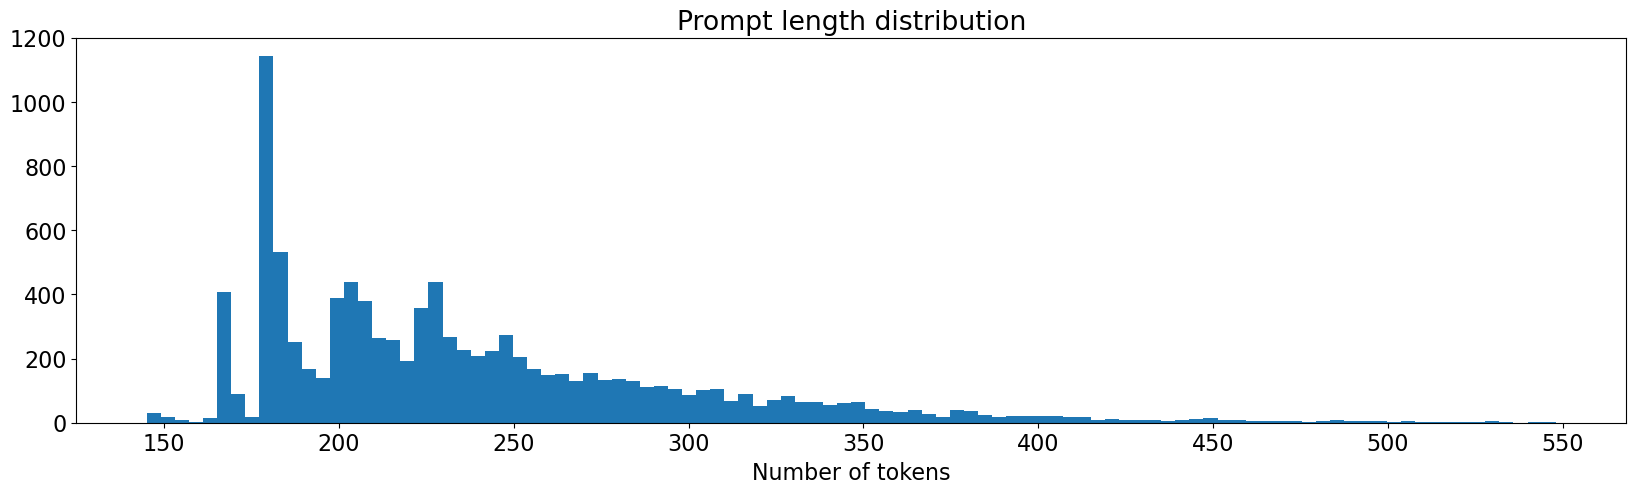

In [17]:
prompt_lengths = [len(tokenizer.encode(prompt)) for prompt in tqdm(prompts)]
plt.hist(prompt_lengths, bins=100);
plt.title('Prompt length distribution')
plt.xlabel('Number of tokens');

In [18]:
print(f'Max prompt length: {max(prompt_lengths)}')

Max prompt length: 548


In [19]:
prompts = [prompt for prompt, prompt_length in zip(prompts, prompt_lengths) if prompt_length < cfg.max_seq_len]
print(f'Using {len(prompts)} prompts after removing those longer than {cfg.max_seq_len} tokens')

Using 9980 prompts after removing those longer than 512 tokens


In [20]:
np.random.seed(cfg.random_seed)
np.random.shuffle(prompts)
train_dataset = Dataset.from_dict({'text': prompts[:-cfg.val_samples]})
val_dataset = Dataset.from_dict({'text': prompts[-cfg.val_samples:]})

In [22]:
len(train_dataset)

8980

## Train

In [21]:
peft_config = LoraConfig(
    # lora_alpha: LoRA scaling factor.
    lora_alpha=64, #64,
    lora_dropout=0.1, # 0.1, althought Vaca suggested to use 0.05 for big models
    # r: the rank of the update matrices, expressed in int. Lower rank results in smaller update matrices with fewer trainable parameters.
    r=16, #16
    bias="none",
    task_type="CAUSAL_LM",
    # target_modules: The modules (for example, attention blocks) to apply the LoRA update matrices.
    target_modules= ['k_proj', 'q_proj', 'v_proj', 'o_proj']
)

In [25]:
logging_steps = len(train_dataset)//16
logging_steps = 50
print(f'Logging steps: {logging_steps}')
training_arguments = TrainingArguments(
        output_dir=cfg.output_dir,
        evaluation_strategy="steps",
        do_eval=True,
        optim="paged_adamw_8bit",
        per_device_train_batch_size=8, # 4-16 should be fine for lora.
        gradient_accumulation_steps=2,
        per_device_eval_batch_size=8,
        log_level="debug",
        save_steps=logging_steps, #50,
        logging_steps=logging_steps, #50,
        learning_rate=4e-5, # maybe we can increase this
        eval_steps=logging_steps, #50,
        max_steps=(len(train_dataset)//16)*10, #300,
        warmup_steps=30,
        lr_scheduler_type="linear",
)

Logging steps: 50


In [27]:
data_collator = DataCollatorForCompletionOnlyLM(
    tokenizer=tokenizer,
    instruction_template='<|user|>',
    response_template='<|assistant|>')

/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/trl/trainer/utils.py:110: UserWarning: The pad_token_id and eos_token_id values of this tokenizer are identical. If you are planning for multi-turn training, it can result in the model continuously generating questions and answers without eos token. To avoid this, set the pad_token_id to a different value.
  warnings.warn(


In [28]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=cfg.max_seq_len,
    data_collator=data_collator,
    args=training_arguments,
)

trainer.train()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/8980 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:294: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
You have loaded a model on multiple GPUs. `is_model_parallel` attribute will be force-set to `True` to avoid any unexpected behavior such as device placement mismatching.
max_steps is given, it will override any value given in num_train_epochs
Currently training with a batch size of: 8
***** Running training *****
  Num examples = 8,980
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 2
  Total optimization steps = 5,610
  Number of trainable parameters = 3,145,728
Automatic Weig

  0%|          | 0/5610 [00:00<?, ?it/s]

You are not running the flash-attention implementation, expect numerical differences.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 1.0541, 'grad_norm': 0.5546875, 'learning_rate': 3.985663082437276e-05, 'epoch': 0.09}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-50
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-50/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-50/special_tokens_map.json


{'eval_loss': 0.38903215527534485, 'eval_runtime': 64.2024, 'eval_samples_per_second': 15.576, 'eval_steps_per_second': 1.947, 'epoch': 0.09}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.3384, 'grad_norm': 0.53125, 'learning_rate': 3.949820788530467e-05, 'epoch': 0.18}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-100
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-100/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-100/special_tokens_map.json


{'eval_loss': 0.3062984049320221, 'eval_runtime': 64.6079, 'eval_samples_per_second': 15.478, 'eval_steps_per_second': 1.935, 'epoch': 0.18}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2849, 'grad_norm': 0.76953125, 'learning_rate': 3.913978494623656e-05, 'epoch': 0.27}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-150
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-150/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-150/special_tokens_map.json


{'eval_loss': 0.2822999358177185, 'eval_runtime': 64.6029, 'eval_samples_per_second': 15.479, 'eval_steps_per_second': 1.935, 'epoch': 0.27}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2726, 'grad_norm': 1.0625, 'learning_rate': 3.8781362007168464e-05, 'epoch': 0.36}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-200
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-200/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-200/special_tokens_map.json


{'eval_loss': 0.26311200857162476, 'eval_runtime': 64.2609, 'eval_samples_per_second': 15.562, 'eval_steps_per_second': 1.945, 'epoch': 0.36}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2552, 'grad_norm': 1.1484375, 'learning_rate': 3.842293906810036e-05, 'epoch': 0.45}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-250
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-250/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-250/special_tokens_map.json


{'eval_loss': 0.24817220866680145, 'eval_runtime': 64.7063, 'eval_samples_per_second': 15.454, 'eval_steps_per_second': 1.932, 'epoch': 0.45}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.241, 'grad_norm': 1.015625, 'learning_rate': 3.806451612903226e-05, 'epoch': 0.53}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-300
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-300/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-300/special_tokens_map.json


{'eval_loss': 0.23969382047653198, 'eval_runtime': 64.1955, 'eval_samples_per_second': 15.577, 'eval_steps_per_second': 1.947, 'epoch': 0.53}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2408, 'grad_norm': 1.9609375, 'learning_rate': 3.770609318996416e-05, 'epoch': 0.62}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-350
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-350/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-350/special_tokens_map.json


{'eval_loss': 0.23747818171977997, 'eval_runtime': 64.4094, 'eval_samples_per_second': 15.526, 'eval_steps_per_second': 1.941, 'epoch': 0.62}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2228, 'grad_norm': 3.5625, 'learning_rate': 3.734767025089606e-05, 'epoch': 0.71}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-400
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-400/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-400/special_tokens_map.json


{'eval_loss': 0.23234085738658905, 'eval_runtime': 63.6353, 'eval_samples_per_second': 15.715, 'eval_steps_per_second': 1.964, 'epoch': 0.71}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2207, 'grad_norm': 1.21875, 'learning_rate': 3.698924731182796e-05, 'epoch': 0.8}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-450
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-450/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-450/special_tokens_map.json


{'eval_loss': 0.22255969047546387, 'eval_runtime': 64.4335, 'eval_samples_per_second': 15.52, 'eval_steps_per_second': 1.94, 'epoch': 0.8}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2202, 'grad_norm': 1.65625, 'learning_rate': 3.663082437275986e-05, 'epoch': 0.89}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-500
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-500/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-500/special_tokens_map.json


{'eval_loss': 0.2227870672941208, 'eval_runtime': 63.9391, 'eval_samples_per_second': 15.64, 'eval_steps_per_second': 1.955, 'epoch': 0.89}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2205, 'grad_norm': 2.859375, 'learning_rate': 3.6272401433691756e-05, 'epoch': 0.98}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-550
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-550/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-550/special_tokens_map.json


{'eval_loss': 0.22627106308937073, 'eval_runtime': 65.563, 'eval_samples_per_second': 15.253, 'eval_steps_per_second': 1.907, 'epoch': 0.98}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2147, 'grad_norm': 4.5625, 'learning_rate': 3.591397849462366e-05, 'epoch': 1.07}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-600
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-600/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-600/special_tokens_map.json


{'eval_loss': 0.2270834594964981, 'eval_runtime': 64.5373, 'eval_samples_per_second': 15.495, 'eval_steps_per_second': 1.937, 'epoch': 1.07}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2128, 'grad_norm': 2.46875, 'learning_rate': 3.555555555555555e-05, 'epoch': 1.16}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-650
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-650/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-650/special_tokens_map.json


{'eval_loss': 0.22873461246490479, 'eval_runtime': 64.3291, 'eval_samples_per_second': 15.545, 'eval_steps_per_second': 1.943, 'epoch': 1.16}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2127, 'grad_norm': 3.8125, 'learning_rate': 3.519713261648746e-05, 'epoch': 1.25}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-700
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-700/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-700/special_tokens_map.json


{'eval_loss': 0.20716291666030884, 'eval_runtime': 64.3079, 'eval_samples_per_second': 15.55, 'eval_steps_per_second': 1.944, 'epoch': 1.25}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2064, 'grad_norm': 4.5625, 'learning_rate': 3.483870967741936e-05, 'epoch': 1.34}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-750
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-750/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-750/special_tokens_map.json


{'eval_loss': 0.21001046895980835, 'eval_runtime': 61.4454, 'eval_samples_per_second': 16.275, 'eval_steps_per_second': 2.034, 'epoch': 1.34}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2031, 'grad_norm': 1.9453125, 'learning_rate': 3.448028673835126e-05, 'epoch': 1.42}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-800
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-800/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-800/special_tokens_map.json


{'eval_loss': 0.21212027966976166, 'eval_runtime': 61.4836, 'eval_samples_per_second': 16.265, 'eval_steps_per_second': 2.033, 'epoch': 1.42}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2086, 'grad_norm': 3.109375, 'learning_rate': 3.4121863799283154e-05, 'epoch': 1.51}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-850
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-850/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-850/special_tokens_map.json


{'eval_loss': 0.20082704722881317, 'eval_runtime': 61.5247, 'eval_samples_per_second': 16.254, 'eval_steps_per_second': 2.032, 'epoch': 1.51}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2086, 'grad_norm': 3.203125, 'learning_rate': 3.3763440860215055e-05, 'epoch': 1.6}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-900
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-900/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-900/special_tokens_map.json


{'eval_loss': 0.20299917459487915, 'eval_runtime': 61.5165, 'eval_samples_per_second': 16.256, 'eval_steps_per_second': 2.032, 'epoch': 1.6}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2007, 'grad_norm': 2.34375, 'learning_rate': 3.340501792114696e-05, 'epoch': 1.69}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-950
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-950/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-950/special_tokens_map.json


{'eval_loss': 0.19850662350654602, 'eval_runtime': 61.4627, 'eval_samples_per_second': 16.27, 'eval_steps_per_second': 2.034, 'epoch': 1.69}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2009, 'grad_norm': 4.8125, 'learning_rate': 3.304659498207885e-05, 'epoch': 1.78}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1000
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1000/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1000/special_tokens_map.json


{'eval_loss': 0.21096238493919373, 'eval_runtime': 61.5491, 'eval_samples_per_second': 16.247, 'eval_steps_per_second': 2.031, 'epoch': 1.78}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2003, 'grad_norm': 3.4375, 'learning_rate': 3.2688172043010754e-05, 'epoch': 1.87}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1050
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1050/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1050/special_tokens_map.json


{'eval_loss': 0.19512584805488586, 'eval_runtime': 61.5658, 'eval_samples_per_second': 16.243, 'eval_steps_per_second': 2.03, 'epoch': 1.87}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1976, 'grad_norm': 5.9375, 'learning_rate': 3.2329749103942656e-05, 'epoch': 1.96}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1100
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1100/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1100/special_tokens_map.json


{'eval_loss': 0.19209171831607819, 'eval_runtime': 61.5283, 'eval_samples_per_second': 16.253, 'eval_steps_per_second': 2.032, 'epoch': 1.96}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1838, 'grad_norm': 3.140625, 'learning_rate': 3.197132616487455e-05, 'epoch': 2.05}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1150
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1150/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1150/special_tokens_map.json


{'eval_loss': 0.19916701316833496, 'eval_runtime': 61.5034, 'eval_samples_per_second': 16.259, 'eval_steps_per_second': 2.032, 'epoch': 2.05}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.19, 'grad_norm': 8.6875, 'learning_rate': 3.161290322580645e-05, 'epoch': 2.14}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1200
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1200/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1200/special_tokens_map.json


{'eval_loss': 0.20638342201709747, 'eval_runtime': 61.5482, 'eval_samples_per_second': 16.247, 'eval_steps_per_second': 2.031, 'epoch': 2.14}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.2038, 'grad_norm': 2.046875, 'learning_rate': 3.1254480286738355e-05, 'epoch': 2.23}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1250
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1250/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1250/special_tokens_map.json


{'eval_loss': 0.1938580423593521, 'eval_runtime': 61.5712, 'eval_samples_per_second': 16.241, 'eval_steps_per_second': 2.03, 'epoch': 2.23}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1868, 'grad_norm': 5.65625, 'learning_rate': 3.0896057347670256e-05, 'epoch': 2.32}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1300
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1300/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1300/special_tokens_map.json


{'eval_loss': 0.18933923542499542, 'eval_runtime': 61.3999, 'eval_samples_per_second': 16.287, 'eval_steps_per_second': 2.036, 'epoch': 2.32}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1989, 'grad_norm': 1.1953125, 'learning_rate': 3.053763440860215e-05, 'epoch': 2.4}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1350
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1350/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1350/special_tokens_map.json


{'eval_loss': 0.19016452133655548, 'eval_runtime': 61.3238, 'eval_samples_per_second': 16.307, 'eval_steps_per_second': 2.038, 'epoch': 2.4}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.194, 'grad_norm': 3.484375, 'learning_rate': 3.017921146953405e-05, 'epoch': 2.49}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1400
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1400/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1400/special_tokens_map.json


{'eval_loss': 0.18972615897655487, 'eval_runtime': 61.3893, 'eval_samples_per_second': 16.289, 'eval_steps_per_second': 2.036, 'epoch': 2.49}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.184, 'grad_norm': 2.296875, 'learning_rate': 2.9820788530465955e-05, 'epoch': 2.58}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1450
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1450/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1450/special_tokens_map.json


{'eval_loss': 0.2045641839504242, 'eval_runtime': 61.3178, 'eval_samples_per_second': 16.308, 'eval_steps_per_second': 2.039, 'epoch': 2.58}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1937, 'grad_norm': 4.5625, 'learning_rate': 2.9462365591397853e-05, 'epoch': 2.67}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1500
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1500/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1500/special_tokens_map.json


{'eval_loss': 0.19456326961517334, 'eval_runtime': 61.3916, 'eval_samples_per_second': 16.289, 'eval_steps_per_second': 2.036, 'epoch': 2.67}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1927, 'grad_norm': 1.9140625, 'learning_rate': 2.9103942652329752e-05, 'epoch': 2.76}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1550
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1550/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1550/special_tokens_map.json


{'eval_loss': 0.19160793721675873, 'eval_runtime': 61.4507, 'eval_samples_per_second': 16.273, 'eval_steps_per_second': 2.034, 'epoch': 2.76}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1926, 'grad_norm': 3.015625, 'learning_rate': 2.874551971326165e-05, 'epoch': 2.85}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1600
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1600/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1600/special_tokens_map.json


{'eval_loss': 0.18720699846744537, 'eval_runtime': 61.3484, 'eval_samples_per_second': 16.3, 'eval_steps_per_second': 2.038, 'epoch': 2.85}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1914, 'grad_norm': 6.3125, 'learning_rate': 2.8387096774193552e-05, 'epoch': 2.94}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1650
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1650/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1650/special_tokens_map.json


{'eval_loss': 0.19231851398944855, 'eval_runtime': 61.4133, 'eval_samples_per_second': 16.283, 'eval_steps_per_second': 2.035, 'epoch': 2.94}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1867, 'grad_norm': 5.09375, 'learning_rate': 2.802867383512545e-05, 'epoch': 3.03}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1700
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1700/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1700/special_tokens_map.json


{'eval_loss': 0.18457433581352234, 'eval_runtime': 61.4657, 'eval_samples_per_second': 16.269, 'eval_steps_per_second': 2.034, 'epoch': 3.03}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1809, 'grad_norm': 2.46875, 'learning_rate': 2.767025089605735e-05, 'epoch': 3.12}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1750
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1750/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1750/special_tokens_map.json


{'eval_loss': 0.18205276131629944, 'eval_runtime': 61.5923, 'eval_samples_per_second': 16.236, 'eval_steps_per_second': 2.029, 'epoch': 3.12}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1857, 'grad_norm': 4.21875, 'learning_rate': 2.7311827956989247e-05, 'epoch': 3.21}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1800
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1800/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1800/special_tokens_map.json


{'eval_loss': 0.18236258625984192, 'eval_runtime': 61.5386, 'eval_samples_per_second': 16.25, 'eval_steps_per_second': 2.031, 'epoch': 3.21}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1902, 'grad_norm': 2.375, 'learning_rate': 2.695340501792115e-05, 'epoch': 3.29}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1850
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1850/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1850/special_tokens_map.json


{'eval_loss': 0.18554821610450745, 'eval_runtime': 61.3892, 'eval_samples_per_second': 16.289, 'eval_steps_per_second': 2.036, 'epoch': 3.29}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1787, 'grad_norm': 3.78125, 'learning_rate': 2.6594982078853048e-05, 'epoch': 3.38}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1900
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1900/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1900/special_tokens_map.json


{'eval_loss': 0.18439605832099915, 'eval_runtime': 61.4289, 'eval_samples_per_second': 16.279, 'eval_steps_per_second': 2.035, 'epoch': 3.38}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1748, 'grad_norm': 5.46875, 'learning_rate': 2.6236559139784946e-05, 'epoch': 3.47}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1950
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1950/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-1950/special_tokens_map.json


{'eval_loss': 0.18485675752162933, 'eval_runtime': 61.3686, 'eval_samples_per_second': 16.295, 'eval_steps_per_second': 2.037, 'epoch': 3.47}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1873, 'grad_norm': 4.40625, 'learning_rate': 2.587813620071685e-05, 'epoch': 3.56}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2000
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2000/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2000/special_tokens_map.json


{'eval_loss': 0.18755611777305603, 'eval_runtime': 61.4011, 'eval_samples_per_second': 16.286, 'eval_steps_per_second': 2.036, 'epoch': 3.56}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.181, 'grad_norm': 18.75, 'learning_rate': 2.551971326164875e-05, 'epoch': 3.65}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2050
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2050/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2050/special_tokens_map.json


{'eval_loss': 0.23197466135025024, 'eval_runtime': 61.4341, 'eval_samples_per_second': 16.278, 'eval_steps_per_second': 2.035, 'epoch': 3.65}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1977, 'grad_norm': 4.34375, 'learning_rate': 2.5161290322580648e-05, 'epoch': 3.74}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2100
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2100/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2100/special_tokens_map.json


{'eval_loss': 0.18724311888217926, 'eval_runtime': 61.4311, 'eval_samples_per_second': 16.278, 'eval_steps_per_second': 2.035, 'epoch': 3.74}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1872, 'grad_norm': 2.453125, 'learning_rate': 2.4802867383512547e-05, 'epoch': 3.83}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2150
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2150/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2150/special_tokens_map.json


{'eval_loss': 0.17993444204330444, 'eval_runtime': 61.4117, 'eval_samples_per_second': 16.284, 'eval_steps_per_second': 2.035, 'epoch': 3.83}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1794, 'grad_norm': 5.4375, 'learning_rate': 2.444444444444445e-05, 'epoch': 3.92}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2200
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2200/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2200/special_tokens_map.json


{'eval_loss': 0.17977334558963776, 'eval_runtime': 61.4455, 'eval_samples_per_second': 16.275, 'eval_steps_per_second': 2.034, 'epoch': 3.92}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1844, 'grad_norm': 4.625, 'learning_rate': 2.4086021505376347e-05, 'epoch': 4.01}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2250
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2250/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2250/special_tokens_map.json


{'eval_loss': 0.17928889393806458, 'eval_runtime': 61.4403, 'eval_samples_per_second': 16.276, 'eval_steps_per_second': 2.034, 'epoch': 4.01}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1759, 'grad_norm': 13.1875, 'learning_rate': 2.3727598566308245e-05, 'epoch': 4.1}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2300
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2300/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2300/special_tokens_map.json


{'eval_loss': 0.1937161087989807, 'eval_runtime': 61.5103, 'eval_samples_per_second': 16.257, 'eval_steps_per_second': 2.032, 'epoch': 4.1}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1771, 'grad_norm': 3.828125, 'learning_rate': 2.3369175627240144e-05, 'epoch': 4.19}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2350
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2350/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2350/special_tokens_map.json


{'eval_loss': 0.1871155947446823, 'eval_runtime': 61.5265, 'eval_samples_per_second': 16.253, 'eval_steps_per_second': 2.032, 'epoch': 4.19}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1769, 'grad_norm': 4.90625, 'learning_rate': 2.3010752688172045e-05, 'epoch': 4.27}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2400
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2400/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2400/special_tokens_map.json


{'eval_loss': 0.1777055859565735, 'eval_runtime': 61.4029, 'eval_samples_per_second': 16.286, 'eval_steps_per_second': 2.036, 'epoch': 4.27}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1708, 'grad_norm': 8.75, 'learning_rate': 2.2652329749103944e-05, 'epoch': 4.36}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2450
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2450/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2450/special_tokens_map.json


{'eval_loss': 0.17613843083381653, 'eval_runtime': 61.3893, 'eval_samples_per_second': 16.289, 'eval_steps_per_second': 2.036, 'epoch': 4.36}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1768, 'grad_norm': 4.9375, 'learning_rate': 2.2293906810035842e-05, 'epoch': 4.45}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2500
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2500/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2500/special_tokens_map.json


{'eval_loss': 0.17605823278427124, 'eval_runtime': 61.3677, 'eval_samples_per_second': 16.295, 'eval_steps_per_second': 2.037, 'epoch': 4.45}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1713, 'grad_norm': 2.65625, 'learning_rate': 2.193548387096774e-05, 'epoch': 4.54}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2550
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2550/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2550/special_tokens_map.json


{'eval_loss': 0.17733453214168549, 'eval_runtime': 61.3326, 'eval_samples_per_second': 16.305, 'eval_steps_per_second': 2.038, 'epoch': 4.54}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1815, 'grad_norm': 2.734375, 'learning_rate': 2.1577060931899646e-05, 'epoch': 4.63}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2600
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2600/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2600/special_tokens_map.json


{'eval_loss': 0.17628350853919983, 'eval_runtime': 61.3967, 'eval_samples_per_second': 16.288, 'eval_steps_per_second': 2.036, 'epoch': 4.63}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1808, 'grad_norm': 1.96875, 'learning_rate': 2.1218637992831544e-05, 'epoch': 4.72}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2650
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2650/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2650/special_tokens_map.json


{'eval_loss': 0.1751950979232788, 'eval_runtime': 61.3343, 'eval_samples_per_second': 16.304, 'eval_steps_per_second': 2.038, 'epoch': 4.72}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1691, 'grad_norm': 4.21875, 'learning_rate': 2.0860215053763443e-05, 'epoch': 4.81}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2700
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2700/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2700/special_tokens_map.json


{'eval_loss': 0.17673788964748383, 'eval_runtime': 61.3978, 'eval_samples_per_second': 16.287, 'eval_steps_per_second': 2.036, 'epoch': 4.81}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1692, 'grad_norm': 3.828125, 'learning_rate': 2.050179211469534e-05, 'epoch': 4.9}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2750
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2750/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2750/special_tokens_map.json


{'eval_loss': 0.17913126945495605, 'eval_runtime': 61.3552, 'eval_samples_per_second': 16.299, 'eval_steps_per_second': 2.037, 'epoch': 4.9}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1859, 'grad_norm': 2.71875, 'learning_rate': 2.0143369175627243e-05, 'epoch': 4.99}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2800
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2800/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2800/special_tokens_map.json


{'eval_loss': 0.18069162964820862, 'eval_runtime': 61.3612, 'eval_samples_per_second': 16.297, 'eval_steps_per_second': 2.037, 'epoch': 4.99}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1794, 'grad_norm': 11.375, 'learning_rate': 1.978494623655914e-05, 'epoch': 5.08}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2850
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2850/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2850/special_tokens_map.json


{'eval_loss': 0.18412722647190094, 'eval_runtime': 61.4203, 'eval_samples_per_second': 16.281, 'eval_steps_per_second': 2.035, 'epoch': 5.08}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1712, 'grad_norm': 2.140625, 'learning_rate': 1.942652329749104e-05, 'epoch': 5.16}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2900
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2900/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2900/special_tokens_map.json


{'eval_loss': 0.1771233230829239, 'eval_runtime': 61.4981, 'eval_samples_per_second': 16.261, 'eval_steps_per_second': 2.033, 'epoch': 5.16}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1667, 'grad_norm': 4.3125, 'learning_rate': 1.906810035842294e-05, 'epoch': 5.25}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2950
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2950/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-2950/special_tokens_map.json


{'eval_loss': 0.17638950049877167, 'eval_runtime': 61.3851, 'eval_samples_per_second': 16.291, 'eval_steps_per_second': 2.036, 'epoch': 5.25}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1722, 'grad_norm': 2.046875, 'learning_rate': 1.870967741935484e-05, 'epoch': 5.34}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3000
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3000/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3000/special_tokens_map.json


{'eval_loss': 0.17804181575775146, 'eval_runtime': 61.3441, 'eval_samples_per_second': 16.301, 'eval_steps_per_second': 2.038, 'epoch': 5.34}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1709, 'grad_norm': 8.1875, 'learning_rate': 1.835125448028674e-05, 'epoch': 5.43}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3050
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3050/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3050/special_tokens_map.json


{'eval_loss': 0.18040858209133148, 'eval_runtime': 61.2312, 'eval_samples_per_second': 16.332, 'eval_steps_per_second': 2.041, 'epoch': 5.43}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1713, 'grad_norm': 6.4375, 'learning_rate': 1.799283154121864e-05, 'epoch': 5.52}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3100
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3100/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3100/special_tokens_map.json


{'eval_loss': 0.1723422259092331, 'eval_runtime': 61.3301, 'eval_samples_per_second': 16.305, 'eval_steps_per_second': 2.038, 'epoch': 5.52}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1707, 'grad_norm': 13.125, 'learning_rate': 1.763440860215054e-05, 'epoch': 5.61}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3150
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3150/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3150/special_tokens_map.json


{'eval_loss': 0.18424437940120697, 'eval_runtime': 61.3576, 'eval_samples_per_second': 16.298, 'eval_steps_per_second': 2.037, 'epoch': 5.61}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1679, 'grad_norm': 4.78125, 'learning_rate': 1.727598566308244e-05, 'epoch': 5.7}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3200
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3200/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3200/special_tokens_map.json


{'eval_loss': 0.17330017685890198, 'eval_runtime': 61.4374, 'eval_samples_per_second': 16.277, 'eval_steps_per_second': 2.035, 'epoch': 5.7}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1728, 'grad_norm': 8.3125, 'learning_rate': 1.691756272401434e-05, 'epoch': 5.79}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3250
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3250/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3250/special_tokens_map.json


{'eval_loss': 0.17184309661388397, 'eval_runtime': 61.4082, 'eval_samples_per_second': 16.284, 'eval_steps_per_second': 2.036, 'epoch': 5.79}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1659, 'grad_norm': 6.9375, 'learning_rate': 1.6559139784946237e-05, 'epoch': 5.88}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3300
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3300/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3300/special_tokens_map.json


{'eval_loss': 0.1796661615371704, 'eval_runtime': 61.4186, 'eval_samples_per_second': 16.282, 'eval_steps_per_second': 2.035, 'epoch': 5.88}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1672, 'grad_norm': 4.46875, 'learning_rate': 1.6200716845878136e-05, 'epoch': 5.97}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3350
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3350/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3350/special_tokens_map.json


{'eval_loss': 0.17205151915550232, 'eval_runtime': 61.4383, 'eval_samples_per_second': 16.276, 'eval_steps_per_second': 2.035, 'epoch': 5.97}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1707, 'grad_norm': 6.90625, 'learning_rate': 1.5842293906810038e-05, 'epoch': 6.06}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3400
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3400/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3400/special_tokens_map.json


{'eval_loss': 0.1742355078458786, 'eval_runtime': 61.5192, 'eval_samples_per_second': 16.255, 'eval_steps_per_second': 2.032, 'epoch': 6.06}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1684, 'grad_norm': 14.625, 'learning_rate': 1.5483870967741936e-05, 'epoch': 6.14}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3450
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3450/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3450/special_tokens_map.json


{'eval_loss': 0.17941971123218536, 'eval_runtime': 61.4076, 'eval_samples_per_second': 16.285, 'eval_steps_per_second': 2.036, 'epoch': 6.14}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1636, 'grad_norm': 4.65625, 'learning_rate': 1.5125448028673838e-05, 'epoch': 6.23}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3500
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3500/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3500/special_tokens_map.json


{'eval_loss': 0.1733252853155136, 'eval_runtime': 61.3768, 'eval_samples_per_second': 16.293, 'eval_steps_per_second': 2.037, 'epoch': 6.23}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1667, 'grad_norm': 3.96875, 'learning_rate': 1.4767025089605736e-05, 'epoch': 6.32}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3550
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3550/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3550/special_tokens_map.json


{'eval_loss': 0.17311905324459076, 'eval_runtime': 61.3725, 'eval_samples_per_second': 16.294, 'eval_steps_per_second': 2.037, 'epoch': 6.32}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1739, 'grad_norm': 6.78125, 'learning_rate': 1.4408602150537636e-05, 'epoch': 6.41}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3600
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3600/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3600/special_tokens_map.json


{'eval_loss': 0.17197035253047943, 'eval_runtime': 61.4015, 'eval_samples_per_second': 16.286, 'eval_steps_per_second': 2.036, 'epoch': 6.41}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1686, 'grad_norm': 2.625, 'learning_rate': 1.4050179211469535e-05, 'epoch': 6.5}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3650
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3650/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3650/special_tokens_map.json


{'eval_loss': 0.17161449790000916, 'eval_runtime': 61.3767, 'eval_samples_per_second': 16.293, 'eval_steps_per_second': 2.037, 'epoch': 6.5}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1727, 'grad_norm': 5.40625, 'learning_rate': 1.3691756272401435e-05, 'epoch': 6.59}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3700
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3700/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3700/special_tokens_map.json


{'eval_loss': 0.17405930161476135, 'eval_runtime': 61.3565, 'eval_samples_per_second': 16.298, 'eval_steps_per_second': 2.037, 'epoch': 6.59}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1676, 'grad_norm': 2.734375, 'learning_rate': 1.3333333333333333e-05, 'epoch': 6.68}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3750
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3750/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3750/special_tokens_map.json


{'eval_loss': 0.16963626444339752, 'eval_runtime': 61.4397, 'eval_samples_per_second': 16.276, 'eval_steps_per_second': 2.035, 'epoch': 6.68}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1601, 'grad_norm': 1.828125, 'learning_rate': 1.2974910394265235e-05, 'epoch': 6.77}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3800
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3800/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3800/special_tokens_map.json


{'eval_loss': 0.18935886025428772, 'eval_runtime': 61.4717, 'eval_samples_per_second': 16.268, 'eval_steps_per_second': 2.033, 'epoch': 6.77}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.174, 'grad_norm': 5.46875, 'learning_rate': 1.2616487455197134e-05, 'epoch': 6.86}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3850
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3850/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3850/special_tokens_map.json


{'eval_loss': 0.16941791772842407, 'eval_runtime': 61.4136, 'eval_samples_per_second': 16.283, 'eval_steps_per_second': 2.035, 'epoch': 6.86}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.163, 'grad_norm': 4.0, 'learning_rate': 1.2258064516129034e-05, 'epoch': 6.95}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3900
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3900/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3900/special_tokens_map.json


{'eval_loss': 0.17023301124572754, 'eval_runtime': 61.4234, 'eval_samples_per_second': 16.28, 'eval_steps_per_second': 2.035, 'epoch': 6.95}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1627, 'grad_norm': 6.53125, 'learning_rate': 1.1899641577060932e-05, 'epoch': 7.03}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3950
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3950/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-3950/special_tokens_map.json


{'eval_loss': 0.17064742743968964, 'eval_runtime': 61.4452, 'eval_samples_per_second': 16.275, 'eval_steps_per_second': 2.034, 'epoch': 7.03}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1636, 'grad_norm': 3.328125, 'learning_rate': 1.1541218637992832e-05, 'epoch': 7.12}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4000
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4000/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4000/special_tokens_map.json


{'eval_loss': 0.16913695633411407, 'eval_runtime': 61.3381, 'eval_samples_per_second': 16.303, 'eval_steps_per_second': 2.038, 'epoch': 7.12}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1704, 'grad_norm': 2.046875, 'learning_rate': 1.118279569892473e-05, 'epoch': 7.21}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4050
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4050/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4050/special_tokens_map.json


{'eval_loss': 0.16997884213924408, 'eval_runtime': 61.2632, 'eval_samples_per_second': 16.323, 'eval_steps_per_second': 2.04, 'epoch': 7.21}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1611, 'grad_norm': 5.25, 'learning_rate': 1.0824372759856632e-05, 'epoch': 7.3}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4100
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4100/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4100/special_tokens_map.json


{'eval_loss': 0.16975750029087067, 'eval_runtime': 61.3004, 'eval_samples_per_second': 16.313, 'eval_steps_per_second': 2.039, 'epoch': 7.3}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1573, 'grad_norm': 11.125, 'learning_rate': 1.0465949820788533e-05, 'epoch': 7.39}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4150
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4150/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4150/special_tokens_map.json


{'eval_loss': 0.17415755987167358, 'eval_runtime': 61.2731, 'eval_samples_per_second': 16.32, 'eval_steps_per_second': 2.04, 'epoch': 7.39}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1619, 'grad_norm': 6.59375, 'learning_rate': 1.0107526881720431e-05, 'epoch': 7.48}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4200
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4200/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4200/special_tokens_map.json


{'eval_loss': 0.17134469747543335, 'eval_runtime': 61.3683, 'eval_samples_per_second': 16.295, 'eval_steps_per_second': 2.037, 'epoch': 7.48}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.163, 'grad_norm': 7.375, 'learning_rate': 9.749103942652331e-06, 'epoch': 7.57}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4250
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4250/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4250/special_tokens_map.json


{'eval_loss': 0.17041058838367462, 'eval_runtime': 61.3898, 'eval_samples_per_second': 16.289, 'eval_steps_per_second': 2.036, 'epoch': 7.57}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1655, 'grad_norm': 3.203125, 'learning_rate': 9.39068100358423e-06, 'epoch': 7.66}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4300
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4300/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4300/special_tokens_map.json


{'eval_loss': 0.1677195429801941, 'eval_runtime': 61.3822, 'eval_samples_per_second': 16.291, 'eval_steps_per_second': 2.036, 'epoch': 7.66}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1645, 'grad_norm': 3.3125, 'learning_rate': 9.03225806451613e-06, 'epoch': 7.75}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4350
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4350/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4350/special_tokens_map.json


{'eval_loss': 0.16823184490203857, 'eval_runtime': 61.42, 'eval_samples_per_second': 16.281, 'eval_steps_per_second': 2.035, 'epoch': 7.75}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1674, 'grad_norm': 11.1875, 'learning_rate': 8.67383512544803e-06, 'epoch': 7.84}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4400
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4400/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4400/special_tokens_map.json


{'eval_loss': 0.16847796738147736, 'eval_runtime': 61.4331, 'eval_samples_per_second': 16.278, 'eval_steps_per_second': 2.035, 'epoch': 7.84}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1598, 'grad_norm': 4.84375, 'learning_rate': 8.315412186379928e-06, 'epoch': 7.93}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4450
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4450/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4450/special_tokens_map.json


{'eval_loss': 0.16797399520874023, 'eval_runtime': 61.4299, 'eval_samples_per_second': 16.279, 'eval_steps_per_second': 2.035, 'epoch': 7.93}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1614, 'grad_norm': 4.84375, 'learning_rate': 7.956989247311828e-06, 'epoch': 8.01}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4500
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4500/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4500/special_tokens_map.json


{'eval_loss': 0.16720892488956451, 'eval_runtime': 61.4902, 'eval_samples_per_second': 16.263, 'eval_steps_per_second': 2.033, 'epoch': 8.01}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1528, 'grad_norm': 2.921875, 'learning_rate': 7.5985663082437275e-06, 'epoch': 8.1}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4550
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4550/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4550/special_tokens_map.json


{'eval_loss': 0.1674610674381256, 'eval_runtime': 61.3502, 'eval_samples_per_second': 16.3, 'eval_steps_per_second': 2.037, 'epoch': 8.1}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1623, 'grad_norm': 3.203125, 'learning_rate': 7.240143369175628e-06, 'epoch': 8.19}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4600
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4600/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4600/special_tokens_map.json


{'eval_loss': 0.16982004046440125, 'eval_runtime': 61.4002, 'eval_samples_per_second': 16.287, 'eval_steps_per_second': 2.036, 'epoch': 8.19}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1642, 'grad_norm': 6.03125, 'learning_rate': 6.881720430107528e-06, 'epoch': 8.28}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4650
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4650/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4650/special_tokens_map.json


{'eval_loss': 0.1689913123846054, 'eval_runtime': 61.3515, 'eval_samples_per_second': 16.3, 'eval_steps_per_second': 2.037, 'epoch': 8.28}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1594, 'grad_norm': 7.28125, 'learning_rate': 6.523297491039428e-06, 'epoch': 8.37}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4700
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4700/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4700/special_tokens_map.json


{'eval_loss': 0.16773614287376404, 'eval_runtime': 61.399, 'eval_samples_per_second': 16.287, 'eval_steps_per_second': 2.036, 'epoch': 8.37}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1614, 'grad_norm': 4.9375, 'learning_rate': 6.164874551971327e-06, 'epoch': 8.46}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4750
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4750/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4750/special_tokens_map.json


{'eval_loss': 0.16697391867637634, 'eval_runtime': 61.351, 'eval_samples_per_second': 16.3, 'eval_steps_per_second': 2.037, 'epoch': 8.46}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1608, 'grad_norm': 2.953125, 'learning_rate': 5.806451612903226e-06, 'epoch': 8.55}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4800
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4800/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4800/special_tokens_map.json


{'eval_loss': 0.16715042293071747, 'eval_runtime': 61.4265, 'eval_samples_per_second': 16.28, 'eval_steps_per_second': 2.035, 'epoch': 8.55}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1594, 'grad_norm': 4.3125, 'learning_rate': 5.4480286738351265e-06, 'epoch': 8.64}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4850
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4850/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4850/special_tokens_map.json


{'eval_loss': 0.16796472668647766, 'eval_runtime': 61.4217, 'eval_samples_per_second': 16.281, 'eval_steps_per_second': 2.035, 'epoch': 8.64}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1625, 'grad_norm': 4.71875, 'learning_rate': 5.089605734767026e-06, 'epoch': 8.73}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4900
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4900/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4900/special_tokens_map.json


{'eval_loss': 0.16886840760707855, 'eval_runtime': 61.4459, 'eval_samples_per_second': 16.274, 'eval_steps_per_second': 2.034, 'epoch': 8.73}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1642, 'grad_norm': 6.65625, 'learning_rate': 4.731182795698925e-06, 'epoch': 8.82}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4950
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4950/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-4950/special_tokens_map.json


{'eval_loss': 0.1670956164598465, 'eval_runtime': 61.422, 'eval_samples_per_second': 16.281, 'eval_steps_per_second': 2.035, 'epoch': 8.82}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1626, 'grad_norm': 4.1875, 'learning_rate': 4.372759856630825e-06, 'epoch': 8.9}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5000
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5000/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5000/special_tokens_map.json


{'eval_loss': 0.16685642302036285, 'eval_runtime': 61.4602, 'eval_samples_per_second': 16.271, 'eval_steps_per_second': 2.034, 'epoch': 8.9}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1562, 'grad_norm': 2.734375, 'learning_rate': 4.0143369175627245e-06, 'epoch': 8.99}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5050
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5050/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5050/special_tokens_map.json


{'eval_loss': 0.16666045784950256, 'eval_runtime': 61.3797, 'eval_samples_per_second': 16.292, 'eval_steps_per_second': 2.037, 'epoch': 8.99}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1563, 'grad_norm': 4.125, 'learning_rate': 3.655913978494624e-06, 'epoch': 9.08}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5100
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5100/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5100/special_tokens_map.json


{'eval_loss': 0.1666136234998703, 'eval_runtime': 61.3522, 'eval_samples_per_second': 16.299, 'eval_steps_per_second': 2.037, 'epoch': 9.08}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1652, 'grad_norm': 5.90625, 'learning_rate': 3.2974910394265234e-06, 'epoch': 9.17}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5150
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5150/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5150/special_tokens_map.json


{'eval_loss': 0.16654200851917267, 'eval_runtime': 61.3378, 'eval_samples_per_second': 16.303, 'eval_steps_per_second': 2.038, 'epoch': 9.17}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1583, 'grad_norm': 2.828125, 'learning_rate': 2.939068100358423e-06, 'epoch': 9.26}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5200
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5200/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5200/special_tokens_map.json


{'eval_loss': 0.166574627161026, 'eval_runtime': 61.3489, 'eval_samples_per_second': 16.3, 'eval_steps_per_second': 2.038, 'epoch': 9.26}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1624, 'grad_norm': 2.890625, 'learning_rate': 2.580645161290323e-06, 'epoch': 9.35}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5250
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5250/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5250/special_tokens_map.json


{'eval_loss': 0.16615374386310577, 'eval_runtime': 63.6822, 'eval_samples_per_second': 15.703, 'eval_steps_per_second': 1.963, 'epoch': 9.35}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1589, 'grad_norm': 3.984375, 'learning_rate': 2.222222222222222e-06, 'epoch': 9.44}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5300
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5300/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5300/special_tokens_map.json


{'eval_loss': 0.16670535504817963, 'eval_runtime': 61.4495, 'eval_samples_per_second': 16.274, 'eval_steps_per_second': 2.034, 'epoch': 9.44}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1633, 'grad_norm': 2.703125, 'learning_rate': 1.8637992831541222e-06, 'epoch': 9.53}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5350
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5350/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5350/special_tokens_map.json


{'eval_loss': 0.1667366623878479, 'eval_runtime': 61.4074, 'eval_samples_per_second': 16.285, 'eval_steps_per_second': 2.036, 'epoch': 9.53}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1496, 'grad_norm': 2.65625, 'learning_rate': 1.5053763440860217e-06, 'epoch': 9.62}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5400
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5400/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5400/special_tokens_map.json


{'eval_loss': 0.16616171598434448, 'eval_runtime': 61.4566, 'eval_samples_per_second': 16.272, 'eval_steps_per_second': 2.034, 'epoch': 9.62}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1559, 'grad_norm': 3.6875, 'learning_rate': 1.1469534050179212e-06, 'epoch': 9.71}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5450
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5450/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5450/special_tokens_map.json


{'eval_loss': 0.16625045239925385, 'eval_runtime': 61.4723, 'eval_samples_per_second': 16.267, 'eval_steps_per_second': 2.033, 'epoch': 9.71}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1616, 'grad_norm': 2.1875, 'learning_rate': 7.885304659498208e-07, 'epoch': 9.8}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5500
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5500/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5500/special_tokens_map.json


{'eval_loss': 0.16647006571292877, 'eval_runtime': 61.4221, 'eval_samples_per_second': 16.281, 'eval_steps_per_second': 2.035, 'epoch': 9.8}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.1572, 'grad_norm': 5.21875, 'learning_rate': 4.301075268817205e-07, 'epoch': 9.88}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5550
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5550/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5550/special_tokens_map.json


{'eval_loss': 0.16618789732456207, 'eval_runtime': 61.44, 'eval_samples_per_second': 16.276, 'eval_steps_per_second': 2.035, 'epoch': 9.88}


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'loss': 0.159, 'grad_norm': 3.03125, 'learning_rate': 7.168458781362007e-08, 'epoch': 9.97}


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model checkpoint to /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5600
/home/gbarbadillo/miniconda3/envs/prometeo/lib/python3.10/site-packages/peft/utils/save_and_load.py:148: UserWarning: Could not find a config file in /home/gbarbadillo/data/Phi-3-mini-128k-instruct - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5600/tokenizer_config.json
Special tokens file saved in /mnt/hdd0/Kaggle/arc24/models/20240724_first_trainings/01_phi3_debug/tmp-checkpoint-5600/special_tokens_map.json


{'eval_loss': 0.16654208302497864, 'eval_runtime': 61.3775, 'eval_samples_per_second': 16.293, 'eval_steps_per_second': 2.037, 'epoch': 9.97}




Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 18385.222, 'train_samples_per_second': 4.882, 'train_steps_per_second': 0.305, 'train_loss': 0.19006722083916214, 'epoch': 9.99}


TrainOutput(global_step=5610, training_loss=0.19006722083916214, metrics={'train_runtime': 18385.222, 'train_samples_per_second': 4.882, 'train_steps_per_second': 0.305, 'train_loss': 0.19006722083916214, 'epoch': 9.99})

- Evaluation for 1k samples is taking around 1 minute.
- One epoch has taken around 30 minutes, with around 11 evaluations. Thus 1/3 of the time was spend evaluating. (550 steps, eval every 50 steps)
- Training for 10 epochs took 5 hours. I set the temperature of the AC to 27ºC and the room was at 22ºC, probably 28ºC is fine.
- Eval loss was 0.1665, without signs of overfit

## TODO

- [ ] The pad_token_id and eos_token_id values of this tokenizer are identical. If you are planning for multi-turn training, it can result in the model continuously generating questions and answers without eos token. To avoid this, set the pad_token_id to a different value.
- [ ] Flash attention?
- [ ] Batch size?
- [ ] Better WANDB configuration
- [ ] Training parameters?